In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import aggregate_downsample
from astropy.timeseries import TimeSeries

/Users/willyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# =============
# Read HST Data
# =============

# Select object
object_name = 'ZTF_J2252_0519'
'''
Select from:
1. YZ_LMi
2. ASASSN_14mv
3. GP_Com
4. ASASSN_14cn
5. ZTF_J2252_0519
'''
data_path = '../HST_DATA/'+object_name+'/'

### Lightcurve analysis

In [3]:
# ==================
# Import Lightcurves
# ==================

lc_file_name = 'ZTF_J2252_0519_lc.txt'
lc = Table.read(lc_file_name, format='ascii')


print(lc)

       MJD                  EXP                COUNT        ... ONES ONES_1
------------------ --------------------- ------------------ ... ---- ------
59900.746821081855 3.472222222222222e-05  62.07826086956522 ...  1.0    1.0
 59900.74685580408 3.472222222222222e-05 61.243478260869566 ...  1.0    1.0
  59900.7468905263 3.472222222222222e-05 62.495652173913044 ...  1.0    1.0
59900.746925248524 3.472222222222222e-05  77.49565217391304 ...  1.0    1.0
 59900.74695997075 3.472222222222222e-05  51.91304347826087 ...  1.0    1.0
 59900.74699469297 3.472222222222222e-05  62.99130434782609 ...  1.0    1.0
 59900.74702941519 3.472222222222222e-05 50.165217391304346 ...  1.0    1.0
 59900.74706413742 3.472222222222222e-05  51.66086956521739 ...  1.0    1.0
 59900.74709885964 3.472222222222222e-05  49.07826086956522 ...  1.0    1.0
 59900.74713358186 3.472222222222222e-05  41.91304347826087 ...  1.0    1.0
               ...                   ...                ... ...  ...    ...
59901.029772

Periodogram results: 
 Transit time = 59900.769529415185 mjd 
 Period = 37.38737522349119 min 
 Peak in range (10.0, 20.0): 19.99961417668539 min 



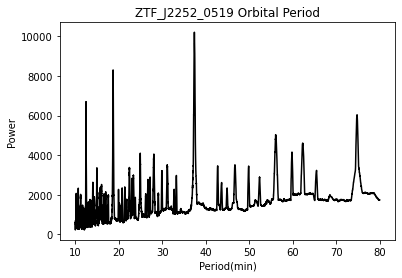

In [4]:
# ===================
# Lightcurve Analysis
# ===================
from astropy.timeseries import BoxLeastSquares

# Compute Orbital Period (Box Least Squares)
model = BoxLeastSquares(t  = lc['MJD']*u.day, 
                        y  = lc['COUNT'], 
                        dy = lc['COUNT_ERROR'])
periodogram = model.autopower(duration       = 1. *u.min, 
                              minimum_period = 10.*u.min, 
                              maximum_period = 80.*u.min)

# Period & Transit_time
period_bls = periodogram.period[np.argmax(periodogram.power)].to(u.min)
t0_bls = Time(periodogram.transit_time[np.argmax(periodogram.power)], format='mjd')

# Check other peaks
p_min = 10 *u.min
p_max = 20 *u.min
x = periodogram.period.to(u.min)
tmp = np.where((x > p_min) & (x < p_max))
print('Periodogram results:', '\n',
      'Transit time =', t0_bls, t0_bls.format, '\n',
      'Period =', period_bls, '\n', 
      f'Peak in range {p_min.value, p_max.value}:', np.max(x[tmp]), '\n')
      

# Converge to Period Frame
plt.plot(periodogram.period.to(u.min), periodogram.power, c='k')
plt.xlabel('Period(min)')
plt.ylabel('Power')
plt.title(object_name+' Orbital Period')
plt.show()

Entered lightcurve parameters: 
 Period: 37.38737522349119 min 
 Transit Time: 59900.769529415185


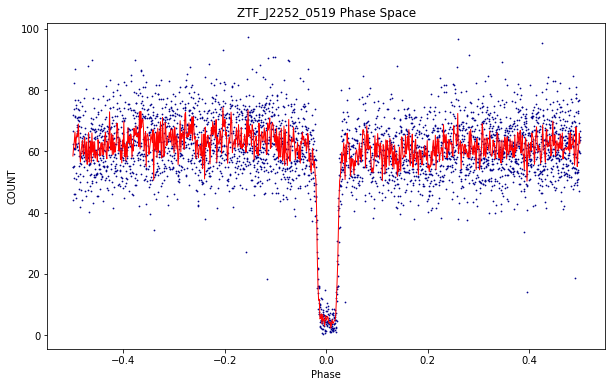

In [5]:
# ===================
# Plot in Phase Space
# ===================
ts = TimeSeries(data=lc, time=Time(lc['MJD'], format='mjd'))

period = period_bls # <======== Best period [with unit]
transit_time = t0_bls # <======== Best transit time [Astropy 'Time' format]
print('Entered lightcurve parameters:', '\n',
      'Period:', period, '\n',
      'Transit Time:', transit_time)

ts_folded = ts.fold(period=period, epoch_time=transit_time)
ts_folded['PHASE'] = ts_folded.time.sec / period.to(u.s) # Normalize time axis to phase

ts_folded_binned = aggregate_downsample(ts_folded, time_bin_size=3*u.s)  

plt.figure(figsize=(10, 6))
plt.plot(ts_folded['PHASE'], ts_folded['COUNT'], '.', color='darkblue', markersize=1.5)
plt.plot(ts_folded_binned['PHASE'], ts_folded_binned['COUNT'], '-', c='r', lw=1)
#plt.ylim(-5e-4, 0.005)
plt.xlabel('Phase')
plt.ylabel('COUNT')
plt.title(object_name+' Phase Space')
plt.show()

In [6]:
# Save phase-folded lightcurve
lc_fold = ts_folded.to_pandas()

phase       = lc_fold['PHASE']
count       = lc_fold['COUNT']
count_error = lc_fold['COUNT_ERROR']
ones        = np.ones(len(phase))
exp         = np.ones(len(phase)) * 3/86400 # exposure time for individual data point

# Write arrays in txt file
header = "PHASE EXP COUNT COUNT_ERROR ONES ONES"
fold_file_name  = str(object_name + '_lc_fold.txt')
print('file save as:', fold_file_name, '\n')
with open(fold_file_name, 'w') as f: 
    f.write(header + "\n")
    for phase,exp,count,count_error,ones,ones in zip(
        phase,exp,count,count_error,ones,ones): 
        f.write(f"{phase} {exp} {count} {count_error} {ones} {ones}\n")

file save as: ZTF_J2252_0519_lc_fold.txt 

